In [1]:
import glob
import os
import random

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

# import spectrogram
# from spectrogram import generate_spec
# from spectrogram import truncate_spec
# from spectrogram import mask_spec
# from spectrogram import add_noise
# from spectrogram import path_to_preprocessing
from spectrogram_class import spectrogram
from spec_input_generator import gen, gen_eval

from datetime import datetime


2022-07-15 08:25:57.869492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 08:25:57.869533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


../data/_OrchideaSOL2020_release/OrchideaSOL2020/


In [2]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')

In [3]:
meta_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0


In [4]:
train_df, test_df = train_test_split(meta_df, stratify=meta_df['Instrument (in full)'], 
                                        train_size=0.8)

In [5]:
next(gen(train_df, return_class = True))

/home/shiya/Documents/Music_transcription_fastai/notebooks/spectrogram_class.py:111: FutureWarning: Pass y=[ 0.00854426 -0.00237479  0.01115664 ... -0.01120878 -0.00944813
 -0.00448555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.spec = librosa.feature.melspectrogram(self.signal, n_mels = 256, hop_length=self.hop, n_fft=self.n_fft)


mel: (256, 130)


ValueError: cannot reshape array of size 1 into shape (16,)

In [ ]:
sample = next(gen(train_df, return_class = True))[0]
sample


mel: (256, 167)


/home/shiya/Documents/Music_transcription_fastai/notebooks/spectrogram_class.py:111: FutureWarning: Pass y=[ 0.00420208 -0.00117004  0.00547845 ... -0.00936996  0.00589242
 -0.00911529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.spec = librosa.feature.melspectrogram(self.signal, n_mels = 256, hop_length=self.hop, n_fft=self.n_fft)


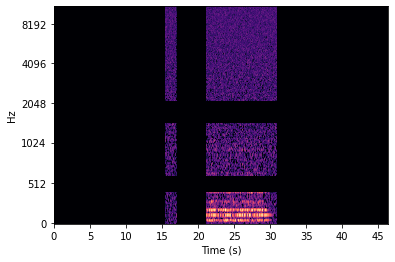

In [ ]:
sample.plot_spec()

In [ ]:
spec_shape = sample.spec.shape

In [ ]:

BATCH_SIZE = 100

train_generator = (tf.data.Dataset.from_generator(lambda: gen(train_df), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)
eval_generator = (tf.data.Dataset.from_generator(lambda: gen_eval(train_df), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)


2022-07-15 08:23:48.624041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 08:23:48.624640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 08:23:48.624741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-15 08:23:48.624814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-15 08:23:48.624871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [ ]:
train_generator

<BatchDataset shapes: ((None, 256, 500, 1), (None, 16)), types: (tf.complex64, tf.int64)>

In [ ]:

model_2conv = models.Sequential()
model_2conv.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1), dtype = tf.float64))
model_2conv.add(layers.Conv2D(30, (150, 20), activation='relu'))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model_2conv.add(layers.MaxPool2D((2, 3)))
model_2conv.add(layers.Conv2D(20, (10, 5), activation = 'relu'))
model_2conv.add(layers.Flatten())
model_2conv.add(layers.Dense(16, activation = 'sigmoid'))
model_2conv.build()

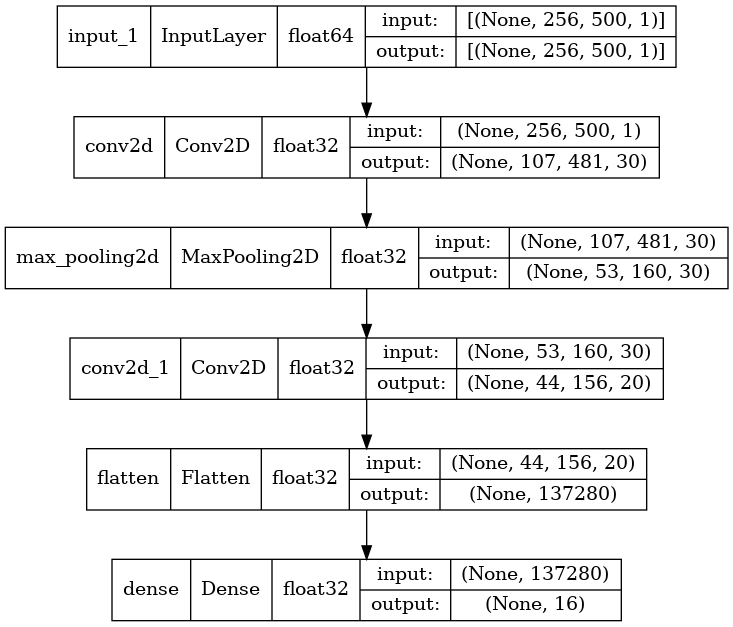

In [ ]:
tf.keras.utils.plot_model(model_2conv, show_shapes = True, show_dtype= True)

In [ ]:

model_2conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_model", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


history = model_2conv.fit(train_generator, epochs = 6, verbose=1, steps_per_epoch= 10, 
                    validation_data = eval_generator,
                    validation_steps = 10, validation_freq= 2, 
                    use_multiprocessing=True, workers = 2, callbacks=[ckpt_callback, early_callback])

Epoch 1/6


/home/shiya/Documents/Music_transcription_fastai/notebooks/spectrogram_class.py:111: FutureWarning: Pass y=[ 0.00178159 -0.00049544  0.00232441 ...  0.00187641  0.00066103
  0.00177193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.spec = librosa.feature.melspectrogram(self.signal, n_mels = 256, hop_length=self.hop, n_fft=self.n_fft)
2022-07-15 08:23:50.102927: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: TypeError: `generator` yielded an element that could not be converted to the expected type. The expected type was int64, but the yielded element was ['Strings' 2.0 'F5' 'None' 0 'mf' 4.0 'artificial_harmonic_tremolo' 'N'
 'Viola' 3.0 77.0 'art_harm_trem' False 'Va' 'Violin Family'].
Traceback (most recent call last):

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1011, in generator_py_func
    script_ops.FuncRegistry._convert(  # pylint: disable=pr

mel: (256, 166)


InvalidArgumentError:  TypeError: `generator` yielded an element that could not be converted to the expected type. The expected type was int64, but the yielded element was ['Strings' 2.0 'F5' 'None' 0 'mf' 4.0 'artificial_harmonic_tremolo' 'N'
 'Viola' 3.0 77.0 'art_harm_trem' False 'Va' 'Violin Family'].
Traceback (most recent call last):

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1011, in generator_py_func
    script_ops.FuncRegistry._convert(  # pylint: disable=protected-access

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 234, in _convert
    result = np.asarray(value, dtype=dtype, order="C")

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py", line 83, in asarray
    return array(a, dtype, copy=False, order=order)

ValueError: invalid literal for int() with base 10: 'Strings'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1015, in generator_py_func
    six.reraise(

  File "/home/shiya/.local/lib/python3.9/site-packages/six.py", line 718, in reraise
    raise value.with_traceback(tb)

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1011, in generator_py_func
    script_ops.FuncRegistry._convert(  # pylint: disable=protected-access

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 234, in _convert
    result = np.asarray(value, dtype=dtype, order="C")

  File "/home/shiya/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py", line 83, in asarray
    return array(a, dtype, copy=False, order=order)

TypeError: `generator` yielded an element that could not be converted to the expected type. The expected type was int64, but the yielded element was ['Strings' 2.0 'F5' 'None' 0 'mf' 4.0 'artificial_harmonic_tremolo' 'N'
 'Viola' 3.0 77.0 'art_harm_trem' False 'Va' 'Violin Family'].


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_806]